# RED NEURONAL.

El objetivo de este trabajo es armar una red neuronal que pueda predecir la siguiente nota. Se elaboraron tres modelos, el basico donde se trabajo primeramente, el siguiente modelo armado con la funcion de activacion softmax y el modelo armado con tensorflow que sirvio de control.

La base de datos elegida es un conjunto de datos que contiene alrededor de 200hs de grabaciones de audio y MIDI emparejadas de diez años de Concurso Internacional de Piano.

FUENTE: https://magenta.tensorflow.org/datasets/maestro

Aclaracion: Este modelo fue el modelo armado con tensorflow que sirvio de control para el modelo donde se utiliza softmax.

In [ ]:
# import zipfile as zf
# files = zf.ZipFile("/content/maestro-v3.0.0-midi.zip", 'r')
# files.extractall('data/')
# files.close()
!pip install pretty_midi
!pip install tensorflow
!pip install scikit-learn

Se instalan todos los paquetes relevantes para procesar y escuchar archivos MIDI, glob para iterar sobre los archivos del dataset, collections para el diccionario con valor por defecto, y pathlib para abrir el archivo.

In [2]:
import collections
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import tensorflow as tf
import itertools
import matplotlib
from sklearn.model_selection import train_test_split

Se define un directorio que contendra todos los archivos MIDI que seran analizados. Se arma una funcion que convierte esos archivos a un DataFrame de pandas donde utilizamos una variable para definir una "nota" que contendra como caracteristica el tono (pitch). Tono es la calidad sonora de la nota, lo que la distingue de otras.

In [3]:
np.random.seed(0)
directorio = pathlib.Path('data/maestro-v2.0.0')
if not directorio.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

filenames = glob.glob(str(directorio/'**/*.mid*'))
print('num archivos:', len(filenames))

# sample_file = "/content/MIDI-Unprocessed_25_R2_2011_MID--AUDIO_R2-D6_07_Track07_wav.midi"
# print(sample_file)

def midi_a_notas(midifile: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midifile)
    instrumento = pm.instruments[0]
    notas = collections.defaultdict(list)

    notas_orden = sorted(instrumento.notes, key=lambda nota: nota.start)
    previa_inicio = notas_orden[0].start

    for nota in notas_orden:
        notas['pitch'].append(nota.pitch)

    return pd.DataFrame({nombre: np.array(valor) for nombre, valor in notas.items()})

num archivos: 1282


Se agrega un fragmento de codigo hecho por otra persona, que permite escribir un dataframe con notas en un archivo midi y lo devuelve como prettyMIDI para poder escucharlo (No se usa):

In [4]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

Se procesan los archivos MIDI, se extraen las notas de cada archivo y se preparan los datos para el modelo del aprendizaje automatico mas adelante.

In [5]:
notasGlobal = []
tam_muestra = 20

for f in filenames[:tam_muestra]:
  notas = midi_a_notas(f)
  notasGlobal.append(notas)

notasGlobal = pd.concat(notasGlobal)
print(notasGlobal.head())
num_notas = len(notasGlobal)

indice_notas = ['pitch']
notas_entrenamiento = np.array([notasGlobal[key] for key in indice_notas]).flatten()
np.set_printoptions(precision=3)
dataset_nota = tf.data.Dataset.from_tensor_slices(notas_entrenamiento)
print(num_notas)
#print(list(dataset_nota.as_numpy_iterator()))

   pitch
0     30
1     35
2     36
3     37
4     38
79790


Luego, transformamos el dataset de las notas en ventanas de secuencias para su uso.

In [6]:
def ventanizar(dataset, tam_ventana, alfabeto_notas = 128,) -> tf.data.Dataset:
  tam_ventana = tam_ventana + 1

  windows = dataset.window(tam_ventana, shift=1, stride=1, drop_remainder=True)
  flatten = lambda x: x.batch(tam_ventana, drop_remainder=True)
  sequences = windows.flat_map(flatten)


  # Normalize tono de las notas
  def normalizar_tono(x):
    x = x/alfabeto_notas
    return x

  # Partimos los indices
  def partir_indices(sequences):
    inputs = sequences[:-1]
    outputs_dense = sequences[-1]
    outputs_dense = tf.one_hot(outputs_dense,128,1,0)
    output = {'pitch':outputs_dense}
    return normalizar_tono(inputs), output
  return sequences.map(partir_indices,num_parallel_calls=tf.data.AUTOTUNE)

ventanitas = ventanizar(dataset_nota, 100)
dataset_pandas = pd.DataFrame(list(ventanitas.as_numpy_iterator()), columns=['inputs','output'])
dataset_pandas.head()


,inputs,output
0,"[0.234375, 0.2734375, 0.28125, 0.2890625, 0.29...","{'pitch': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,"[0.2734375, 0.28125, 0.2890625, 0.296875, 0.30...","{'pitch': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[0.28125, 0.2890625, 0.296875, 0.3046875, 0.31...","{'pitch': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,"[0.2890625, 0.296875, 0.3046875, 0.3125, 0.320...","{'pitch': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,"[0.296875, 0.3046875, 0.3125, 0.3203125, 0.328...","{'pitch': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [7]:
ventanitas.element_spec
for seq, target in ventanitas.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (100,)
sequence elements (first 10): tf.Tensor([0.234 0.273 0.281 0.289 0.297 0.305 0.312 0.32  0.328 0.336], shape=(10,), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(128,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>}


Se preparan las configuraciones necesarias para la red. Este modelo trabaja con una capa de salida con activacion softmax.

In [8]:
batch_size = 100
buffer_size = num_notas - 100  # tamaño ventana
dataset_train = (ventanitas
                .shuffle(buffer_size)
                .batch(batch_size, drop_remainder=True)
                .cache()
                .prefetch(tf.data.experimental.AUTOTUNE))
inputs = tf.keras.Input(100,1)
hidden = tf.keras.layers.Dense(110, name= 'hidden', activation='relu')(inputs)
output = tf.keras.layers.Dense(128, name='pitch', activation='softmax')(hidden)

dataset_train.element_spec

(TensorSpec(shape=(100, 100), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(100, 128), dtype=tf.int32, name=None)})

In [9]:
model = tf.keras.Model(inputs, output)
loss = {'pitch': tf.keras.losses.CategoricalCrossentropy()}
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)
model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(1, 100)]                0         
                                                                 
 hidden (Dense)              (1, 110)                  11110     
                                                                 
 pitch (Dense)               (1, 128)                  14208     
                                                                 
Total params: 25318 (98.90 KB)
Trainable params: 25318 (98.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Se calcula la perdida total y la precision del modelo en el dataset de entrenamiento.

In [10]:
losses = model.evaluate(dataset_train, return_dict=True)
losses

796/796 [==============================] - 23s 2ms/step - loss: 4.9531 - acc: 0.0037


{'loss': 4.953138828277588, 'acc': 0.0036809046287089586}

Se etrena la red

In [11]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [12]:
%%time
epochs = 1000

history = model.fit(
    dataset_train,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/1000
796/796 [==============================] - 3s 3ms/step - loss: 4.1312 - acc: 0.0286
Epoch 2/1000
796/796 [==============================] - 2s 3ms/step - loss: 4.0674 - acc: 0.0288
Epoch 3/1000
796/796 [==============================] - 2s 2ms/step - loss: 4.0567 - acc: 0.0300
Epoch 4/1000
796/796 [==============================] - 2s 2ms/step - loss: 4.0438 - acc: 0.0308
Epoch 5/1000
796/796 [==============================] - 2s 2ms/step - loss: 4.0286 - acc: 0.0324
Epoch 6/1000
796/796 [==============================] - 2s 2ms/step - loss: 4.0122 - acc: 0.0335
Epoch 7/1000
796/796 [==============================] - 2s 3ms/step - loss: 3.9957 - acc: 0.0346
Epoch 8/1000
796/796 [==============================] - 2s 2ms/step - loss: 3.9795 - acc: 0.0356
Epoch 9/1000
796/796 [==============================] - 2s 2ms/step - loss: 3.9636 - acc: 0.0365
Epoch 10/1000
796/796 [==============================] - 2s 2ms/step - loss: 3.9482 - acc: 0.0373
Epoch 11/1000
796/796 [======

Se grafica la funcion de perdida segun las iteraciones.

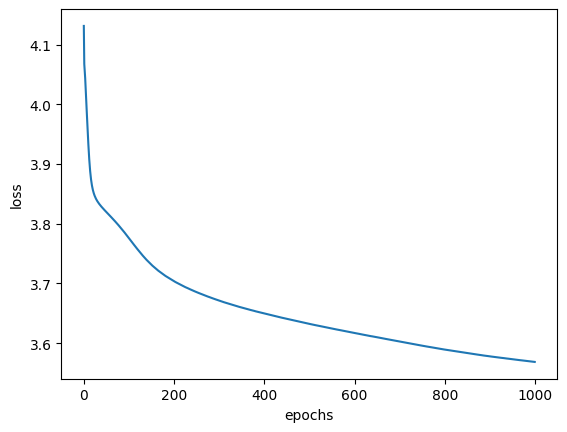

In [13]:
matplotlib.pyplot.plot(history.epoch, history.history['loss'], label='total loss')
matplotlib.pyplot.xlabel('epochs')
matplotlib.pyplot.ylabel('loss')
matplotlib.pyplot.show()